# Build 3D coordinates of congeneric series
> An example of building 3D coordinates of congeneric series using RDKit

- toc: true 
- badges: true
- comments: true
- categories: [rdkit]

# Motivation

I often have to modify a given molecule to introduce a set of modification to make congeneric series. [AllChem.ConstrainedEmbed](http://rdkit.org/docs/source/rdkit.Chem.AllChem.html#rdkit.Chem.AllChem.ConstrainedEmbed) in RDKit could provide such function. See below blog posts for an example:

* http://rdkit.blogspot.com/2013/12/using-allchemconstrainedembed.html
* https://iwatobipen.wordpress.com/2019/06/04/constrain-embedding-with-mcs-as-a-core-rdkit-chemoinformatics/
* https://www.blopig.com/blog/2019/06/constrained-embedding-with-rdkit/

However, `AllChem.ConstrinedEmbed` uses MCS algorithm, and the MCS sometimes did not yielded the core that I desired, which resulted in a completely wrong alignment between the parent and the newly modified molecule.

So, I wrote a small function that takes the SMARTS pattern, and explicitly takes the coordinates then embed the rest of the coordinates.

In [31]:
#collapse-hide
from io import BytesIO
import pandas as pd
import numpy as np
from rdkit.Chem import PandasTools

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import DataStructs
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import rdRGroupDecomposition

from rdkit.Chem.Draw import IPythonConsole #Needed to show molecules
from rdkit.Chem import Draw
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem.Draw.MolDrawing import MolDrawing, DrawingOptions #Only needed if modifying defaults

DrawingOptions.bondLineWidth=1.8
IPythonConsole.ipython_useSVG=True
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.warning')
import rdkit
import py3Dmol
print(rdkit.__version__)

2020.03.2


# Example

Let's use Imatinib for the parent molecule as an example.

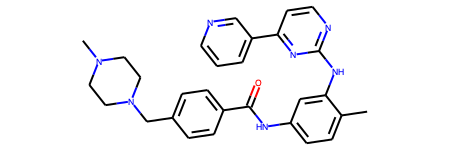

In [7]:
imatinib = Chem.MolFromMolFile('files/STI.sdf')
imatinib_2d = Chem.RemoveHs(imatinib)
AllChem.Compute2DCoords(imatinib_2d)
imatinib_2d

And suppose we want to replace the piperazine to a phenyl.

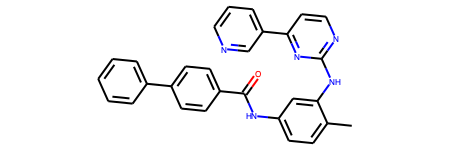

In [12]:
mol_new = Chem.MolFromSmiles('Cc1ccc(NC(=O)c2ccc(c3ccccc3)cc2)cc1Nc1nccc(-c2cccnc2)n1')
mol_new

# SMARTS Pattern

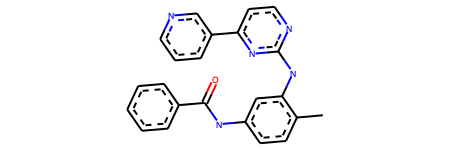

In [24]:
smarts = '[#6]1:[#6]:[#7]:[#6]:[#6](:[#6]:1)-[#6]1:[#7]:[#6](:[#7]:[#6]:[#6]:1)-[#7]-[#6]1:[#6]:[#6](:[#6]:[#6]:[#6]:1-[#6])-[#7]-[#6](-[#6]1:[#6]:[#6]:[#6](:[#6]:[#6]:1))=[#8]'
p = Chem.MolFromSmarts(smarts)
p

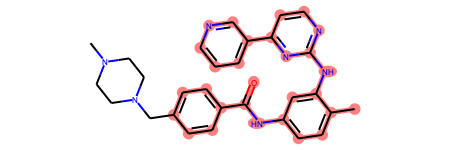

In [27]:
# confirm the SMARTS pattern is what we intended
imatinib_2d.GetSubstructMatch(p)
imatinib_2d

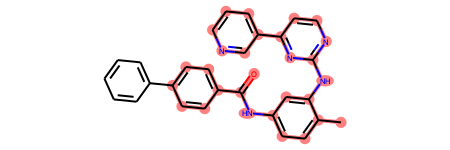

In [28]:
mol_new.GetSubstructMatch(p)
mol_new

# Build the new conformer

In [29]:
from rdkit.Chem import rdFMCS
from rdkit.Chem import rdDistGeom
from rdkit.Chem.rdForceFieldHelpers import UFFGetMoleculeForceField

def build(ref, m, smarts):
    mol = Chem.AddHs(m)

    p = Chem.MolFromSmarts(smarts)
    match1 = ref.GetSubstructMatch(p)
    match2 = mol.GetSubstructMatch(p)

    coordMap = {}
    coreConf = ref.GetConformer(0)
    for i, idxI in enumerate(match2):
        corePtI = coreConf.GetAtomPosition(match1[i])
        coordMap[idxI] = corePtI

    algMap = [(j, match1[i]) for i, j in enumerate(match2)]
    tdist = 0.25
    
    confid = AllChem.EmbedMolecule(mol, coordMap=coordMap)
    rms = AllChem.AlignMol(mol, ref, atomMap=algMap)
    ff = UFFGetMoleculeForceField(mol, confId=0)
    conf = ref.GetConformer()
    for i in range(len(match1)):
        p = conf.GetAtomPosition(match1[i])
        pIdx = ff.AddExtraPoint(p.x, p.y, p.z, fixed=True) - 1
        ff.AddDistanceConstraint(pIdx, match2[i], 0, tdist, 100.)
    ff.Initialize()
    n = 4

    more = ff.Minimize(energyTol=1e-4, forceTol=1e-3)
    while more and n:
        more = ff.Minimize(energyTol=1e-4, forceTol=1e-3)
        n -= 1
    # realign
    rms = AllChem.AlignMol(mol, ref, atomMap=algMap)
    return mol

In [30]:
mol_new = build(imatinib, mol_new, smarts)

You can see the new molecule have very similar coordinates except the newly added phenyl ring in 3D.

In [44]:
viewer = py3Dmol.view(width=300, height=300)
viewer.addModel(Chem.MolToMolBlock(imatinib), 'mol')
viewer.addModel(Chem.MolToMolBlock(mol_new), 'mol')
viewer.setStyle({"stick":{}})
viewer.zoomTo()
viewer.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Note you can perform a fragment grafting instead of embedding. See https://pschmidtke.github.io/blog/rdkit/3d-editor/2021/01/23/grafting-fragments.html